In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow
import keras
import seaborn as sns

In [531]:
f1=pd.read_csv("final_raw_to_use.csv")

In [532]:
from cmath import nan


f1=f1.replace(-99,nan)
f1=f1.replace(99,nan)

In [533]:
f1 = f1[f1.isnull().sum(axis=1) < 5] # taking only objects for which less than 5 band flux is unknown

In [534]:
f1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31870 entries, 0 to 38426
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            31870 non-null  int64  
 1   f365w         24047 non-null  float64
 2   f396w         25543 non-null  float64
 3   f427w         30096 non-null  float64
 4   f458w         27761 non-null  float64
 5   f489w         31639 non-null  float64
 6   f520w         31639 non-null  float64
 7   f551w         29805 non-null  float64
 8   f582w         31564 non-null  float64
 9   f613w         31370 non-null  float64
 10  f644w         31713 non-null  float64
 11  f675w         31767 non-null  float64
 12  f706w         31860 non-null  float64
 13  f737w         31855 non-null  float64
 14  f768w         31756 non-null  float64
 15  f799w         31699 non-null  float64
 16  f830w         31432 non-null  float64
 17  f861w         31674 non-null  float64
 18  f892w         29961 non-nu

In [535]:
f1.fillna(f1.median().round(3), inplace=True)

In [536]:
f1.columns

Index(['id', 'f365w', 'f396w', 'f427w', 'f458w', 'f489w', 'f520w', 'f551w',
       'f582w', 'f613w', 'f644w', 'f675w', 'f706w', 'f737w', 'f768w', 'f799w',
       'f830w', 'f861w', 'f892w', 'f923w', 'f954w', 'j', 'h', 'ks', 'f814w',
       'fwhm', 'stellar_flag', 'g/s'],
      dtype='object')

In [537]:
len(f1[(f1["f814w"]<22.5) & (f1["g/s"]==0)])

5991

In [538]:
len(f1[(f1["f814w"]<26) & (f1["g/s"]==1)])

2247

In [419]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<22.5]

X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

In [421]:
len(y[y==1]) # no. of stars

1764

# checking best performing model 

## ANN

In [422]:
from keras.layers import Dense, Activation,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [447]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [424]:
def ANN(no_of_neurons,no_of_layers,dropout,activation,learning_rate):   # difining neural net
    model=Sequential()
    model.add(Dense(no_of_neurons,input_dim=x_train.shape[1],activation=activation))
    model.add(BatchNormalization())
    for i in range(no_of_layers):
     model.add(Dense(no_of_neurons,activation))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=learning_rate),metrics=["accuracy"])
    return model

In [425]:
def plot_training(training):               # function to check overfitting via graph
    acc_values = training['accuracy']
    val_acc_values = training['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
test_model=KerasClassifier(build_fn=ANN)    # hyperparameterizing defined neural net
param_grid={
    'no_of_neurons':[25,40,75],
    'no_of_layers':[2,3,4],
    'dropout':[0.3,0.5,0.7],
    "activation":['relu','LeakyRelu'],
    "learning_rate":[0.003]
}

cv=GridSearchCV(estimator=test_model,param_grid=param_grid,cv=3,n_jobs=-1)
cv.fit(x_train,y_train)
print(cv.best_params_)

In [428]:
model=ANN(no_of_neurons=25,no_of_layers=2,activation='relu',learning_rate=0.003,dropout=0.5)

In [429]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping               # for getting the best accuracy in all epoches

checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
early_stopping = EarlyStopping( patience=200, restore_best_weights=True)

In [32]:
training_history=model.fit(x_train,y_train,epochs=500,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])

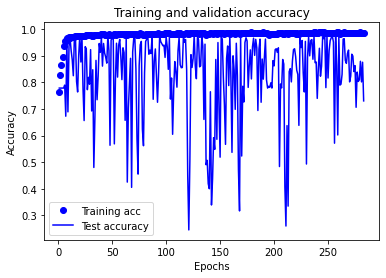

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
training_info=training_history.history
plot_training(training_info)
training_info.keys()

we can see its highly prone to overfitting

In [68]:
predict=model.predict(x_test)

37/37 [==============================] - 0s 2ms/step


auc score

In [69]:
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9912940431575884

now classifying by gradually adding features.Starting from 20 optical bands 

In [434]:
score_ann=[]
predicted_class_ann=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    model=Sequential()
    model.add(Dense(25,input_dim=x_train_new.shape[1],activation='relu'))
    model.add(BatchNormalization())
    for i in range(2):
     model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.003),metrics=["accuracy"])
    
    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=200, restore_best_weights=True)
   
    model.fit(x_train_new,y_train,epochs=500,batch_size=500,verbose=0,validation_data=[x_test_new,y_test],callbacks=[checkpoint,early_stopping])

    predict=model.predict(x_test_new)
    score_ann.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_ann.append(predict)

37/37 [==============================] - 0s 2ms/step


In [435]:
score_ann

[0.8981723907798141,
 0.9785966083132263,
 0.9828105481116416,
 0.9868833102315314]

# RANDOMFOREST

In [44]:
from sklearn.ensemble import RandomForestClassifier

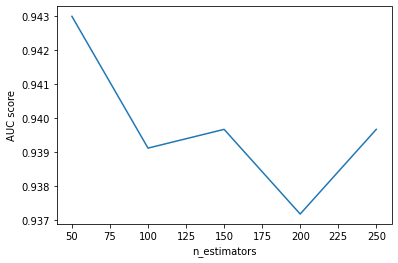

In [46]:
n_estimators=[50,100,150,200,250]      # getting best no. of trees 
test_area=[]
for estimator in n_estimators:
    rf=RandomForestClassifier(n_estimators=estimator,n_jobs=-1)
    rf.fit(x_train,y_train)
    predict=rf.predict(x_test)
    roc_auc=roc_auc_score(y_test,predict)
    test_area.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line=plt.plot(n_estimators,test_area)
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()


In [51]:
param_grid={
    'n_estimators':[50,100,200],
    'min_samples_split':[2,4]
}

cv=GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(x_train,y_train)
print(cv.best_params_)

{'min_samples_split': 2, 'n_estimators': 200}


In [74]:
rf=RandomForestClassifier(n_estimators=200,min_samples_split=2,n_jobs=-1)
rf.fit(x_train,y_train)
predict=rf.predict_proba(x_test)

In [81]:
predict=pd.DataFrame(data=predict)
predict=predict[1].values

auc score

In [87]:
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9898929616510086

running while gradually adding features

In [443]:
score_rf=[]
predicted_class_rf=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    rf=RandomForestClassifier(n_estimators=150+10*i,min_samples_split=2,n_jobs=-1)
    rf.fit(x_train_new,y_train)
    predict=rf.predict_proba(x_test_new)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
   

    score_rf.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_rf.append(predict)

In [444]:
score_rf

[0.9691762068552459,
 0.9847271420504133,
 0.9829902287934014,
 0.9890309221897086]

# CNN

In [88]:
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense, Activation,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [125]:
X=f2.drop(["id",'g/s','stellar_flag'],axis=1).values
y=f2['g/s'].values

In [126]:
X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [128]:
x_test.shape

(1164, 25)

In [129]:
trainX = x_train.reshape(6591,25,1)           
x_train = trainX / 255.0
testX = x_test.reshape(1164,25,1)
x_test = testX / 255.0

In [267]:
model=Sequential()
model.add(Convolution2D(32,kernel_size=(5, 1), input_shape=(25,1,1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(3,1)))
model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(2,1)))
model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])


In [268]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

In [269]:
training_history=model.fit(x_train,y_train,epochs=1000,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])

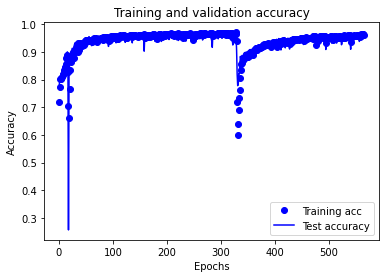

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [270]:
training_info=training_history.history
plot_training(training_info)
training_info.keys()

In [271]:
predict=model.predict(x_test)

37/37 [==============================] - 0s 1ms/step


auc score

In [272]:
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9822030562828346

In [273]:
predict=pd.DataFrame(predict,columns=['pred_class'])

predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1

# Ada Boost

In [484]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [485]:
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

In [486]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [120]:
param_grid={
    'n_estimators':[10,50,100],
    'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=4)]
}
CV_etr = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, cv=5,n_jobs=-1)
CV_etr.fit(x_train, y_train)
print(CV_etr.best_params_)

{'base_estimator': DecisionTreeClassifier(max_depth=4), 'n_estimators': 100}


In [121]:
ada=AdaBoostClassifier(n_estimators=100,base_estimator=(DecisionTreeClassifier(max_depth=4)) )
ada.fit(x_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   n_estimators=100)

In [122]:
predict=ada.predict_proba(x_test)

In [123]:
predict=pd.DataFrame(data=predict)
predict=predict[1].values

auc

In [124]:
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9893089994352894

running while adding features

In [490]:
score_ada=[]
predicted_class_ada=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    ada=AdaBoostClassifier(n_estimators=50+10*i,base_estimator=(DecisionTreeClassifier(max_depth=4)) )
    ada.fit(x_train_new,y_train)

    predict=ada.predict_proba(x_test_new)
   
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values

    score_ada.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_ada.append(predict)

In [491]:
score_ada

[0.9022579872341152, 0.972175162996047, 0.967276725362356, 0.986019131714496]

Therefore we can see that CNN is giving best performance with least overfitting, for F814W < 22.5

# classifying by gradually adding features for F814<22.5

In [372]:
f3=f1.copy(deep=True)

f3=f3[f3['f814w']<22.5]

X=f3.drop(["id",'g/s','stellar_flag'],axis=1)
y=f3['g/s']

c=X.columns
X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(data=X)
for i in range(25):
 X.rename(columns={i:c[i]},inplace=True)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [373]:
score_1=[]
predicted_class_1=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5
    model=Sequential()
    model.add(Convolution2D(32,kernel_size=(k, 1), input_shape=(20+i,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

    x_train_new=x_train.iloc[:,0:20+i].values
    x_test_new=x_test.iloc[:,0:20+i].values
    y_train_new=y_train.values
    y_test_new=y_test.values

    trainX = x_train_new.reshape(6591,20+i,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(1164,20+i,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_1.append(roc_auc_score(y_test_new,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_1.append(predict)
    


37/37 [==============================] - 0s 2ms/step


In [374]:
score_1

[0.983674726628677, 0.9834180399404486, 0.9857581669147971, 0.9864768896418366]

# classifying by gradually adding features for F814<26

In [563]:
f4=f1.copy(deep=True)

f4=f4[f4['f814w']<26]

X=f4.drop(["id",'g/s','stellar_flag'],axis=1)
y=f4['g/s']

c=X.columns
X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(data=X)
for i in range(25):
 X.rename(columns={i:c[i]},inplace=True)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [376]:
score_2=[]
predicted_class_2=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5
    model=Sequential()
    model.add(Convolution2D(32,kernel_size=(k, 1), input_shape=(20+i,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(64,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

    x_train_new=x_train.iloc[:,0:20+i].values
    x_test_new=x_test.iloc[:,0:20+i].values
    y_train_new=y_train.values
    y_test_new=y_test.values

    trainX = x_train_new.reshape(27082,20+i,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(4780,20+i,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_2.append(roc_auc_score(y_test_new,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_2.append(predict)

150/150 [==============================] - 0s 2ms/step


In [377]:
score_2

[0.9616374538372648,
 0.9662914387150126,
 0.9665547447614893,
 0.9664961574826056]

# now classifying objects for various ranges of F814W

In [539]:
score_814=[]
FPS_rate=[]
TPS_rate=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
    
    f5=f1.copy()
    f5=f5[(f5['f814w']<=i)&(f5['f814w']>j)]

    X=f5.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f5['g/s']
    c=X.columns
    X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
    X=pd.DataFrame(data=X)
    for i in range(25):
       X.rename(columns={i:c[i]},inplace=True)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
    
    
    model=Sequential()
    model.add(Convolution2D(32,kernel_size=(5, 1), input_shape=(25,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

    x_train_new=x_train.values
    x_test_new=x_test.values
    y_train_new=y_train.values
    y_test_new=y_test.values
    
    len_train=x_train_new.shape[0]
    len_test=x_test_new.shape[0]

    trainX = x_train_new.reshape(len_train,25,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(len_test,25,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_814.append(roc_auc_score(y_test_new,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate.append(false_positive_rate)
    TPS_rate.append(true_positive_rate)

    

150/150 [==============================] - 0s 2ms/step


In [540]:
score_814

[0.9812840215082316,
 0.8778011875119709,
 0.8301937370537347,
 0.7146703296703297,
 0.9625357921134787]

# RESULTS

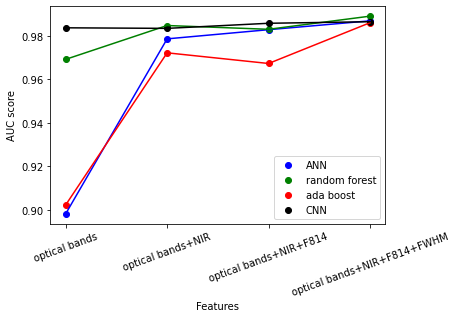

In [503]:
data_0=pd.DataFrame(data={"features":['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],"ANN":score_ann,"Random Forest":score_rf,"Ada boost":score_ada,"CNN":score_1})
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ann,color="blue",alpha=1,label="ANN")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ann,color="blue",alpha=1)
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_rf,color="green",alpha=1,label="random forest")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_rf,color="green",alpha=1)
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ada,color="red",alpha=1,label="ada boost")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ada,color="red",alpha=1)
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1,label="CNN")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1)
plt.ylabel('AUC score')
plt.xlabel('Features')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [558]:
data_0

,features,ANN,Random Forest,Ada boost,CNN
0,optical bands,0.898172,0.969176,0.902258,0.983675
1,optical bands+NIR,0.978597,0.984727,0.972175,0.983418
2,optical bands+NIR+F814,0.982811,0.982990,0.967277,0.985758
3,optical bands+NIR+F814+FWHM,0.986883,0.989031,0.986019,0.986477


Auc score for different no. of features using CNN

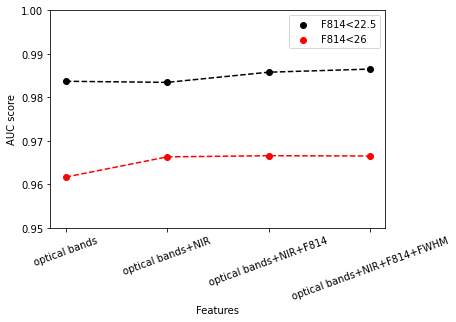

In [521]:
result_1=pd.DataFrame({'information used':['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],'F814<22.5':score_1,'F814<26':score_2})
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1,label="F814<22.5")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1,ls='dashed')
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_2,color="red",alpha=1,label="F814<26")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_2,color="red",alpha=1,ls='dashed')
plt.ylim(ymin=0.95,ymax=1)
plt.ylabel('AUC score')
plt.xlabel('Features')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [555]:
result_1

,information used,F814<22.5,F814<26
0,optical bands,0.983675,0.961637
1,optical bands+NIR,0.983418,0.966291
2,optical bands+NIR+F814,0.985758,0.966555
3,optical bands+NIR+F814+FWHM,0.986477,0.966496


Roc curve for different ranges of F814 using CNN

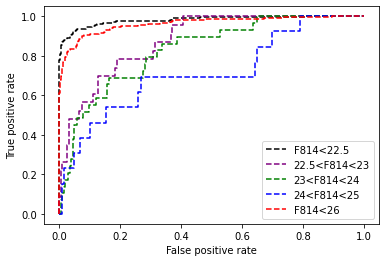

In [545]:
result_2=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814})
plt.plot(FPS_rate[0],TPS_rate[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate[1],TPS_rate[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate[2],TPS_rate[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate[3],TPS_rate[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate[4],TPS_rate[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [556]:
result_2

,F814,AUC score
0,F814<22.5,0.981284
1,22.5<F814<23,0.877801
2,23<F814<24,0.830194
3,24<F814<25,0.714670
4,F814<26,0.962536


now comparing alhambras stellar flag and our predicted data

In [577]:
f4=f1.copy(deep=True)
f4=f4[f4['f814w']<26]
X=f4.drop(['g/s'],axis=1)
y=f4['g/s']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
x_test=pd.DataFrame(data=x_test['stellar_flag'],columns=['stellar_flag'])
x_test=x_test.reset_index()
x_test.drop('index',axis=1,inplace=True)
all_class=predicted_class_2[0].merge(x_test,left_index=True,right_index=True)
all_class.drop(all_class[all_class['stellar_flag']==0.5].index,inplace=True)
all_class.loc[all_class["stellar_flag"]<0.5, "stellar_flag"] = 0
all_class.loc[all_class["stellar_flag"]>0.5, "stellar_flag"] = 1

from sklearn.metrics import accuracy_score

In [603]:
all_class

,pred_class,stellar_flag
4,0.0,0.0
15,0.0,0.0
19,0.0,0.0
31,0.0,0.0
34,0.0,0.0
...,...,...
4767,0.0,0.0
4771,1.0,1.0
4774,0.0,0.0
4777,0.0,0.0


accuracy

In [610]:
accuracy_score(all_class['stellar_flag'],all_class['pred_class'],)

0.9556907037358818

therefore we can see that alhambras classification and our classification is pretty much same